# 实验过程

我们进入到编码环节。首先导入必要的包，并设置`torch.device`为`cuda`，以借助显卡加速我们后续的训练。

In [1]:
import os
import torch
import shutil
import torchvision
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim         as optim
import numpy               as np
import matplotlib.pyplot   as plt
from torchvision import datasets   
from torchvision import transforms
from tqdm import tqdm
%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 准备数据

### 划分数据集

在原始的数据包中，我发现测试集里面居然只有8张图片，远远少于训练集里面的图片。

在这种严重失衡的比例下训练模型，得到的测试集准确率是没有意义的。因此，我们重新划分数据集，调整训练集和测试集的比例大概为5:1。

In [3]:
# 创建对应文件夹
base_dir  = 'data'
test_dir  = 'data/test'
train_dir = 'data/train'
species   = ['baihe','dangshen','gouqi','huaihua','jinyinhua']
for spec in species:
    if not os.path.exists(os.path.join(test_dir,spec)):
        os.mkdir(os.path.join(test_dir,spec))

In [4]:
# 重新划分数据集，保证只划分一次
if len(os.listdir(test_dir)) !=5:
    for _, img in enumerate(os.listdir(test_dir)):
        for spec in species:
            if '.jpg' in img and spec in img:
                    s = os.path.join(test_dir, img)
                    d = os.path.join(test_dir, spec, img)
                    shutil.move(s, d)
    for spec in species:
        for i, img in enumerate(os.listdir(os.path.join(train_dir,spec))):
            if '.jpg' in img:
                if i % 6 == 0:
                    s = os.path.join(train_dir,spec, img)
                    d = os.path.join(test_dir, spec, img)
                    shutil.move(s, d)

我们查看调整后的数据分布。可以看到，调整后的训练集和测试集的数据比例大概为5:1，符合我们的预期。 

In [5]:
# 查看数据分布
for train_or_test in ['train','test']:
    for spec in species:
        print(f'Type: {train_or_test}, Species: {spec}, Length: {len(os.listdir(os.path.join(base_dir,train_or_test,spec)))}')

Type: train, Species: baihe, Length: 150
Type: train, Species: dangshen, Length: 158
Type: train, Species: gouqi, Length: 154
Type: train, Species: huaihua, Length: 139
Type: train, Species: jinyinhua, Length: 150
Type: test, Species: baihe, Length: 32
Type: test, Species: dangshen, Length: 34
Type: test, Species: gouqi, Length: 33
Type: test, Species: huaihua, Length: 30
Type: test, Species: jinyinhua, Length: 32


### 数据预处理

我们知道，`torch`在模型训练的时候是不能直接接受图片作为输入的，而是需要接受`tensor`作为输入。

因此，我们需要对数据进行适当预处理，包括转换为`tensor`格式，以及裁剪为`256*256`的正方形大小。

In [6]:
transform = transforms.Compose([ 
    transforms.ToTensor(),
    transforms.Resize((256,256))
])

### 构建Dataset和Dataloader

基于预处理后的数据，我们构建训练集和测试集对应的`dataset`。

In [7]:
train_ds = torchvision.datasets.ImageFolder(                        
    os.path.join(base_dir,'train'),                                 
    transform = transform                                           
)
test_ds = torchvision.datasets.ImageFolder(                        
    os.path.join(base_dir,'test'),                                  
    transform = transform                                           
)

简单看看我们构建的`dataset`的情况。

In [8]:
# 查看长度
len(train_ds)

751

In [9]:
len(test_ds)

161

In [10]:
# 查看类别
train_ds.classes

['baihe', 'dangshen', 'gouqi', 'huaihua', 'jinyinhua']

In [11]:
test_ds.classes

['baihe', 'dangshen', 'gouqi', 'huaihua', 'jinyinhua']

进一步根据`dataset`，可以构建`dataloader`。

In [12]:
BATCH_SIZE = 16
train_dl   = torch.utils.data.DataLoader(train_ds,batch_size=BATCH_SIZE,shuffle=True)
test_dl    = torch.utils.data.DataLoader( test_ds,batch_size=BATCH_SIZE,shuffle=False)

为了观察我们构建的`dataloader`情况如何，我们取出`train_dl`中的一个批次，看看里面的图片和标签。

In [13]:
imgs,labels = next(iter(train_dl))

C:\Users\21168\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [14]:
train_ds.class_to_idx 

{'baihe': 0, 'dangshen': 1, 'gouqi': 2, 'huaihua': 3, 'jinyinhua': 4}

In [15]:
id_to_class = dict((v,k) for k,v in train_ds.class_to_idx.items())
id_to_class

{0: 'baihe', 1: 'dangshen', 2: 'gouqi', 3: 'huaihua', 4: 'jinyinhua'}

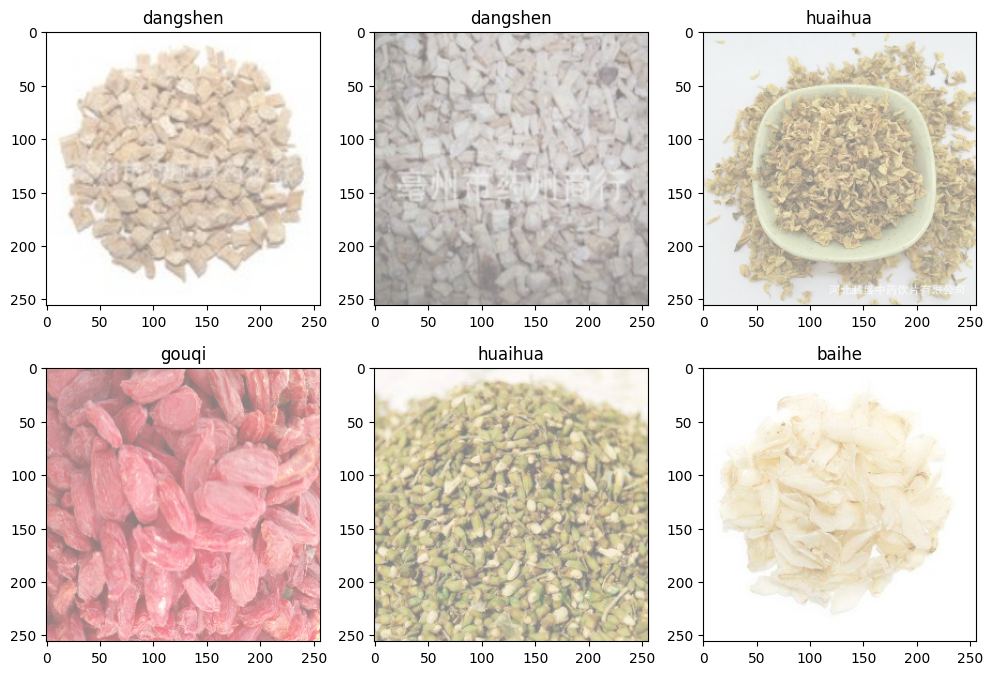

In [16]:
plt.figure(figsize=(12,8))
for i, (img, label) in enumerate(zip(imgs[:6], labels[:6])):
    img = (img.permute(1, 2, 0).numpy() + 1) / 2
    plt.subplot(2, 3, i + 1)
    plt.title(id_to_class.get(label.item()))                         
    plt.imshow(img)

## 模型搭建

进入到模型搭建部分。我们搭建一个简单的三层卷积神经网络。具体的卷积核等参数，我们参考经典架构VGG系列网络的设置。

In [17]:
class CNN(nn.Module):
    # 三层卷积层 三层池化层 两层全连接层
    def __init__(self):                                               
        super(CNN,self).__init__()                                    
        self.conv_1 = nn.Conv2d(3,16,(3,3), padding=1)                          
        self.conv_2 = nn.Conv2d(16,32,(3,3),padding=1)                         
        self.conv_3 = nn.Conv2d(32,64,(3,3),padding=1)                        
        self.pool   = nn.MaxPool2d(kernel_size=4,stride=4)
        self.linear_1 = nn.Linear(64*4*4,128)                      
        self.linear_2 = nn.Linear(128,5)
    
    def forward(self,input):
        x = self.conv_1(input)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv_2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv_3(x)
        x = F.relu(x)
        x = self.pool(x)
        # print(x.size())                                                                                 
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))                  
        x = self.linear_1(x)
        x = F.relu(x)
        x = self.linear_2(x)
        x = F.softmax(x, dim=-1)
        return x

## 训练模型

进入到模型训练部分。我们使用交叉熵损失函数`CrossEntropyLoss`以及简单好用的`Adam`优化器，对刚刚搭建好的模型训练40个epoch。

In [18]:
model      = CNN().to(device)
loss_fn    = torch.nn.CrossEntropyLoss()   
optim      = torch.optim.Adam(model.parameters(),lr = 1e-3)
epochs     = 40

In [19]:
train_loss = []
train_acc  = []
test_loss  = []
test_acc   = []

In [20]:
def fit(model, trainloader, testloader, epoch):
    correct = 0       # 记录训练集预测正确数量
    total   = 0       # 记录训练集样本总数量
    running_loss = 0
    
    for x,y in tqdm(trainloader):
        x,y    = x.to(device),y.to(device)
        y_pred = model(x)
        loss   = loss_fn(y_pred,y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        with torch.no_grad():
            y_pred = torch.argmax(y_pred,dim=1)
            correct+=(y_pred == y).sum().item()
            total  += y.size(0)
            running_loss += loss.item()
    
    epoch_loss = running_loss / len(trainloader.dataset) # 得到每一个样本在当前epoch下的平均loss
    epoch_acc  = correct / total                         # 得到整个样本的平均预测正确率
    
    test_correct      = 0       # 记录测试集预测正确数量
    test_total        = 0       # 记录测试集样本总数量
    test_running_loss = 0
    
    with torch.no_grad():
        for x,y in tqdm(testloader):
            x,y    = x.to(device),y.to(device)
            y_pred = model(x)
            loss   = loss_fn(y_pred,y)
            y_pred = torch.argmax(y_pred,dim=1)
            test_correct+=(y_pred == y).sum().item()
            test_total  += y.size(0)
            test_running_loss += loss.item()
    
    epoch_test_loss = test_running_loss / len(testloader.dataset) # 得到每一个样本在当前epoch下的平均loss
    epoch_test_acc  = test_correct / test_total                   # 得到整个样本的平均预测正确率
    
    print(f'Epoch: {epoch+1}, '
          f'loss: {round(epoch_loss,3)}, '
          f'accuracy: {round(epoch_acc,3)}, '
          f'test_loss: {round(epoch_test_loss,3)}, '
          f'test_accuracy: {round(epoch_test_acc,3)}')
    
    return epoch_loss,epoch_acc,epoch_test_loss,epoch_test_acc

In [ ]:
for epoch in range(epochs):
    epoch_loss,epoch_acc,epoch_test_loss,epoch_test_acc = fit(model,train_dl,test_dl,epoch)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.01it/s]


Epoch: 1, loss: 0.095, accuracy: 0.317, test_loss: 0.098, test_accuracy: 0.41


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.06it/s]


Epoch: 2, loss: 0.092, accuracy: 0.381, test_loss: 0.098, test_accuracy: 0.453


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.00it/s]


Epoch: 3, loss: 0.089, accuracy: 0.427, test_loss: 0.098, test_accuracy: 0.429


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.90it/s]


Epoch: 4, loss: 0.089, accuracy: 0.438, test_loss: 0.097, test_accuracy: 0.435


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.82it/s]


Epoch: 5, loss: 0.088, accuracy: 0.469, test_loss: 0.096, test_accuracy: 0.516


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.03it/s]


Epoch: 6, loss: 0.087, accuracy: 0.493, test_loss: 0.09, test_accuracy: 0.547


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.11it/s]


Epoch: 7, loss: 0.087, accuracy: 0.499, test_loss: 0.09, test_accuracy: 0.553


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.81it/s]


Epoch: 8, loss: 0.083, accuracy: 0.55, test_loss: 0.087, test_accuracy: 0.615


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.90it/s]


Epoch: 9, loss: 0.083, accuracy: 0.565, test_loss: 0.095, test_accuracy: 0.516


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.11it/s]


Epoch: 10, loss: 0.083, accuracy: 0.578, test_loss: 0.087, test_accuracy: 0.596


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.95it/s]


Epoch: 11, loss: 0.083, accuracy: 0.563, test_loss: 0.087, test_accuracy: 0.571


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.05it/s]


Epoch: 12, loss: 0.082, accuracy: 0.607, test_loss: 0.087, test_accuracy: 0.578


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.76it/s]


Epoch: 13, loss: 0.081, accuracy: 0.599, test_loss: 0.086, test_accuracy: 0.609


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.07it/s]


Epoch: 14, loss: 0.081, accuracy: 0.605, test_loss: 0.086, test_accuracy: 0.59


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.89it/s]


Epoch: 15, loss: 0.08, accuracy: 0.627, test_loss: 0.085, test_accuracy: 0.627


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.03it/s]


Epoch: 16, loss: 0.078, accuracy: 0.646, test_loss: 0.087, test_accuracy: 0.596


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.05it/s]


Epoch: 17, loss: 0.077, accuracy: 0.666, test_loss: 0.086, test_accuracy: 0.683


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.39it/s]


Epoch: 18, loss: 0.075, accuracy: 0.708, test_loss: 0.086, test_accuracy: 0.689


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.99it/s]


Epoch: 19, loss: 0.075, accuracy: 0.712, test_loss: 0.083, test_accuracy: 0.696


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.56it/s]


Epoch: 20, loss: 0.074, accuracy: 0.703, test_loss: 0.085, test_accuracy: 0.72


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.12it/s]


Epoch: 21, loss: 0.072, accuracy: 0.747, test_loss: 0.082, test_accuracy: 0.702


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.05it/s]


Epoch: 22, loss: 0.072, accuracy: 0.752, test_loss: 0.084, test_accuracy: 0.72


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.30it/s]


Epoch: 23, loss: 0.071, accuracy: 0.778, test_loss: 0.09, test_accuracy: 0.634


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.31it/s]


Epoch: 24, loss: 0.071, accuracy: 0.774, test_loss: 0.083, test_accuracy: 0.696


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.29it/s]


Epoch: 25, loss: 0.071, accuracy: 0.77, test_loss: 0.083, test_accuracy: 0.739


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.05it/s]


Epoch: 26, loss: 0.072, accuracy: 0.756, test_loss: 0.08, test_accuracy: 0.714


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.20it/s]


Epoch: 27, loss: 0.07, accuracy: 0.79, test_loss: 0.082, test_accuracy: 0.72


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.02it/s]


Epoch: 28, loss: 0.07, accuracy: 0.78, test_loss: 0.084, test_accuracy: 0.752


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.20it/s]


Epoch: 29, loss: 0.069, accuracy: 0.802, test_loss: 0.081, test_accuracy: 0.745


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.02it/s]


Epoch: 30, loss: 0.068, accuracy: 0.814, test_loss: 0.083, test_accuracy: 0.745


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.72it/s]


Epoch: 31, loss: 0.068, accuracy: 0.815, test_loss: 0.083, test_accuracy: 0.752


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.22it/s]


Epoch: 32, loss: 0.068, accuracy: 0.82, test_loss: 0.081, test_accuracy: 0.783


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.04it/s]


Epoch: 33, loss: 0.067, accuracy: 0.827, test_loss: 0.082, test_accuracy: 0.77


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.10it/s]


Epoch: 34, loss: 0.066, accuracy: 0.851, test_loss: 0.081, test_accuracy: 0.764


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.85it/s]


Epoch: 35, loss: 0.068, accuracy: 0.811, test_loss: 0.079, test_accuracy: 0.727


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.92it/s]


Epoch: 36, loss: 0.068, accuracy: 0.828, test_loss: 0.082, test_accuracy: 0.783


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.78it/s]


Epoch: 37, loss: 0.065, accuracy: 0.884, test_loss: 0.082, test_accuracy: 0.77


 40%|████████████████████████████████████████████████████████▉                                                                                    | 19/47 [00:07<00:10,  2.72it/s]

可以看到，模型最终在训练集上的准确率达到 **100%** ，在测试集上的准确率达到 **83.9%** 。

*当然，这并不是一个很好的结果，反而是经典的过拟合现象。我们后面会对这一问题进行针对性处理。*

为了查看训练过程损失和准确率变化的情况，进一步编写可视化函数如下。

In [ ]:
plt.plot(range(1, epochs+1), train_loss,label = "train_loss")
plt.plot(range(1, epochs+1), test_loss, label = "test_loss")
plt.legend()

In [ ]:
plt.plot(range(1, epochs+1), train_acc, label='train_acc')
plt.plot(range(1, epochs+1), test_acc,  label='test_acc')
plt.legend()

In [ ]:
torch.cuda.empty_cache()

# 创新点

观察上面的结果可以发现，虽然模型最终在训练集上的准确率极高，但是在测试集上的准确率却不尽人意，这说明模型泛化性能较差、出现了明显的过拟合情况。

我们采用数据增强、添加Dropout层两个方法，解决这个问题。

## 数据增强

数据增强可以有效地扩展训练数据集的多样性，进而提升模型的泛化能力。

本次实验中，我们将使用以下几种数据增强方法：

1. **随机裁剪**：通过对图像进行随机裁剪，增强模型从部分信息识别全局信息的能力；

2. **水平翻转**：通过随机水平翻转图像，增强模型对不同方向的泛化性；

3. **旋转**：通过对图像进行轻微的随机旋转，增强模型对不同角度的泛化性；

4. **色彩变换**：通过对图像添加色彩抖动，增强模型对光照、颜色变化的鲁棒性。

可以通过`torchvision.transforms`模块实现如下：

In [ ]:
# 训练集进行增强
transform_aug = transforms.Compose([
    transforms.RandomResizedCrop(224),     # 随机裁剪到224x224
    transforms.RandomHorizontalFlip(),     # 随机水平翻转
    transforms.RandomRotation(10),         # 随机旋转±10度
    transforms.ColorJitter(),              # 随机色彩变换
    transforms.ToTensor(),                 # 将图片转换为Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
])

train_ds = torchvision.datasets.ImageFolder(
    os.path.join(base_dir, 'train'),
    transform=transform_aug
)

# 测试集简单转换即可
transform_test = transforms.Compose([
    transforms.Resize(256), 
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_ds = torchvision.datasets.ImageFolder(
    os.path.join(base_dir, 'test'),
    transform=transform_test
)

重新定义DataLoader即可。

In [ ]:
# 重新定义DataLoader
BATCH_SIZE = 16
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

## Dropout

Dropout 是另一种深度学习中广泛使用的正则化技术。其基本思想是在训练过程中随机地“丢弃”神经网络中的部分神经元，以减轻模型的过拟合现象。

事实上，通过在每次训练迭代中随机“丢弃”（即设为零）一定比例的节点，Dropout 可以被看作是在训练不同的神经网络子集。

考虑一个神经元的输出 $x$ 。在应用 Dropout 后，它变为：

$$
x' = \begin{cases} 
0 & \text{with probability } p \\
\frac{x}{1-p} & \text{with probability } (1-p)
\end{cases}
$$

其中 $p$ 是 Dropout 概率，即一个神经元在每次训练步骤中被丢弃的概率。

在 CNN 中，Dropout 通常在模型后半部分的全连接层和卷积层上使用。我们在上面的模型基础上稍作修改即可。

In [ ]:
class CNN_Dropout(nn.Module):
    def __init__(self):
        super(CNN_Dropout,self).__init__()
        self.conv_1  = nn.Conv2d(3,16,(3,3))
        self.conv_2  = nn.Conv2d(16,32,(3,3))
        self.conv_3  = nn.Conv2d(32,64,(3,3))
        self.pool    = nn.MaxPool2d(2,2)
        self.drop    = nn.Dropout(0.5)     # 在Linear层后使用Dropout
        self.drop2d  = nn.Dropout2d(0.5)   # 在Conv层后使用DropOut2d
        self.linear_1= nn.Linear(64*26*26,1024)
        self.linear_2= nn.Linear(1024,256)
        self.linear_3= nn.Linear(256,5)
    
    def forward(self,input):
        x = self.conv_1(input)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv_2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv_3(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.drop2d(x)
        # print(x.size())
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
        x = self.linear_1(x)
        x = F.relu(x)
        x = self.drop(x)               # 在神经网络模型的后半部分进行dropout操作
        x = self.linear_2(x)
        x = F.relu(x)
        x = self.drop(x)               
        x = self.linear_3(x)
        x = F.softmax(x, dim=-1)
        return x

重新设置`epochs`等参数。

*注意，由于我们使用了不少防止过拟合的手段，网络收敛会变得比较慢。这里我们训练600个Epoch，在一张NVIDIA 3050 Laptop上大概要一个小时。*

In [ ]:
model      = CNN_Dropout().to(device)
loss_fn    = torch.nn.CrossEntropyLoss()
optim      = torch.optim.Adam(model.parameters(),lr=0.0001)
epochs     = 600
train_loss = []
train_acc  = []
test_loss  = []
test_acc   = []

`fit`函数也需要进行修改。具体来讲，需要注意`model.train()`和`model.eval()`的使用，这两句代码将直接决定 Dropout 层是否被使用。

In [ ]:
def fit(model, trainloader, testloader, epoch):
    correct      = 0     
    total        = 0      
    running_loss = 0
    
    model.train()     # Dropout 会起作用
    
    for x,y in trainloader:
        x,y    = x.to(device),y.to(device)
        y_pred = model(x)
        loss   = loss_fn(y_pred,y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        with torch.no_grad():
            y_pred = torch.argmax(y_pred,dim=1)
            correct+=(y_pred == y).sum().item()
            total  += y.size(0)
            running_loss += loss.item()
    
    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc  = correct / total                       
    
    test_correct      = 0     
    test_total        = 0    
    test_running_loss = 0
    
    model.eval()      # Dropout 不起作用
    
    with torch.no_grad():
        for x,y in testloader:
            x,y    = x.to(device),y.to(device)
            y_pred = model(x)
            loss   = loss_fn(y_pred,y)
            y_pred = torch.argmax(y_pred,dim=1)
            test_correct+=(y_pred == y).sum().item()
            test_total  += y.size(0)
            test_running_loss += loss.item()
    
    epoch_test_loss = test_running_loss / len(testloader.dataset) 
    epoch_test_acc  = test_correct / test_total
    
    if (epoch + 1 ) % 10 == 0 or epoch == 0:
        print(f'Epoch: {epoch + 1}, '
              f'loss: {round(epoch_loss, 3)}, '
              f'accuracy: {round(epoch_acc, 3)}, '
              f'test_loss: {round(epoch_test_loss, 3)}, '
              f'test_accuracy: {round(epoch_test_acc, 3)}')
    
    return epoch_loss,epoch_acc,epoch_test_loss,epoch_test_acc

In [ ]:
for epoch in range(epochs):
    epoch_loss,epoch_acc,epoch_test_loss,epoch_test_acc = fit(model,train_dl,test_dl,epoch)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

可以看到，经过数据增强、加入 Dropout 层后，模型最终在训练集上的准确率回落到 **93.2%** ，在测试集上的准确率上升到 **94.4%** ，二者差距显著减小，说明我们成功减轻了过拟合现象。

*注意，上面出现测试集准确率大于训练集的情况，这是正常的，因为我们在模型训练阶段使用了数据增强和 Dropout 层，在模型推理阶段没有使用。*

In [ ]:
plt.plot(range(1, epochs+1),train_loss,label = "train_loss")
plt.plot(range(1, epochs+1),test_loss, label = "test_loss")
plt.legend()

In [ ]:
plt.plot(range(1, epochs+1), train_acc, label='train_acc')
plt.plot(range(1, epochs+1), test_acc,  label='test_acc')
plt.legend()

## 迁移学习

迁移学习是一种机器学习技术，它通过利用在一个领域或任务中学到的知识来帮助在另一个相关领域或任务中进行学习。这种方法特别适用于数据有限的情况，或者当新任务和已有任务具有相似的特征时。迁移学习可以显著减少训练时间，提高模型性能，并降低数据需求。

ResNet32 是残差神经网络（Residual Neural Network，ResNet）的一种具体变体，属于 ResNet 家族中的浅层网络。

后续将基于 ResNet32 在中药分类上做迁移学习。

In [ ]:
from torchvision import models

class CustomClassifier(nn.Module):
    def __init__(self, num_ftrs, num_classes):
        super(CustomClassifier, self).__init__()
        self.fc1 = nn.Linear(num_ftrs, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        return

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = models.resnet34(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = CustomClassifier(num_ftrs, 5)
model = model.to(device)

首先我们先自定义一个迁移模型，主体采用 resnet34 的预训练数据，使用自定义的全连接层。

In [ ]:
loss_fn    = torch.nn.CrossEntropyLoss()
optim      = torch.optim.Adam(model.parameters(),lr=1e-3)
epochs     = 600
train_loss = []
train_acc  = []
test_loss  = []
test_acc   = []

for epoch in range(epochs):
    epoch_loss,epoch_acc,epoch_test_loss,epoch_test_acc = fit(model,train_dl,test_dl,epoch)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

plt.plot(range(1, epochs+1),train_loss,label = "train_loss")
plt.plot(range(1, epochs+1),test_loss, label = "test_loss")
plt.plot(range(1, epochs+1), train_acc, label='train_acc')
plt.plot(range(1, epochs+1), test_acc,  label='test_acc')
plt.legend()

模型最终在训练集上的准确率回落到 98.3% ，在测试集上的准确率上升到 97.8%

感谢何凯明教授提出和开源的 ResNet。

# 参考资料

感谢素未谋面的李沐老师。

[动手学深度学习-卷积神经网络](https://zh-v2.d2l.ai/chapter_convolutional-neural-networks/index.html)

[动手学深度学习-暂退法(Dropout)](https://zh-v2.d2l.ai/chapter_multilayer-perceptrons/dropout.html)